In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
import os

# Path to the uploaded zip file
zip_path = '/content/drive/MyDrive/MY DATA/images.zip'  # Update this path as per your Drive structure
output_path = '/content/images'

# Unzip the folder
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_path)

print("Data extracted to:", output_path)


Data extracted to: /content/images


In [14]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from PIL import Image
# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.applications import InceptionV3
# import Early Stopping/Callbacks
from tensorflow.keras.callbacks import EarlyStopping
# import Image Data Generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [15]:
data = '/content/images/images'

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation for training and validation
datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize images
    rotation_range=40,       # Random rotations
    width_shift_range=0.2,   # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,         # Shear
    zoom_range=0.2,          # Zoom
    horizontal_flip=True,    # Flip images
    fill_mode='nearest',     # Fill empty pixels created by transformations
    validation_split=0.2     # Split into training and validation sets
)

# Training generator
train_generator = datagen.flow_from_directory(
    data,  # Path to the data
    target_size=(224, 224),  # Resize images
    batch_size=32,
    class_mode='categorical',  # Multi-class classification
    subset='training'         # Use the training subset
)

# Validation generator
validation_generator = datagen.flow_from_directory(
    data,  # Same path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'       # Use the validation subset
)


Found 320 images belonging to 10 classes.
Found 79 images belonging to 10 classes.


In [17]:
# Display some information about the dataset
print("Dataset Information:")
print(f'Training samples: {train_generator.samples}')
print(f'Validation samples: {validation_generator.samples}')
print(f'Class indices: {train_generator.class_indices}')

Dataset Information:
Training samples: 320
Validation samples: 79
Class indices: {'apple fruit': 0, 'banana fruit': 1, 'cherry fruit': 2, 'grapes fruit': 3, 'kiwi fruit': 4, 'mango fruit': 5, 'orange fruit': 6, 'pinenapple fruit': 7, 'strawberry fruit': 8, 'watermelon fruit': 9}


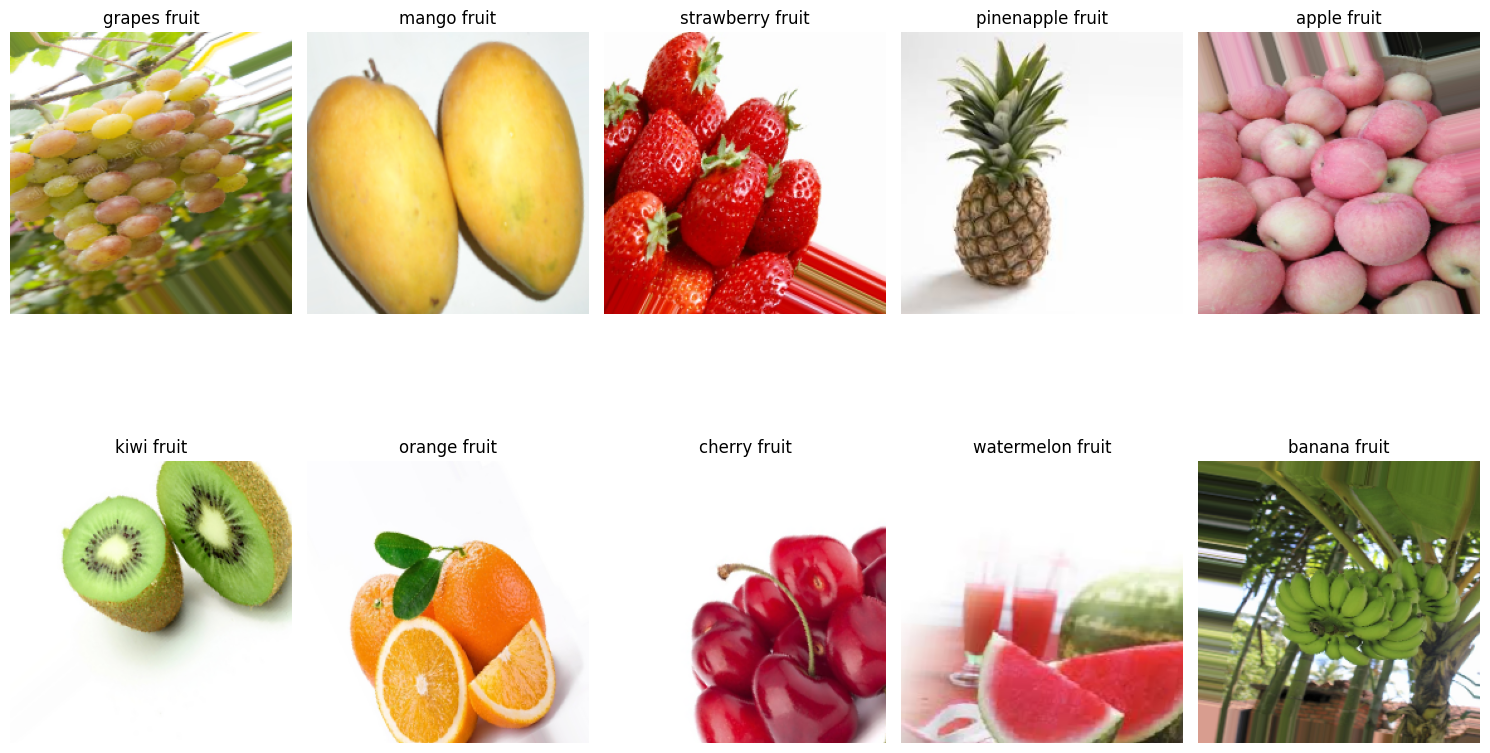

In [ ]:
# Retrieve a batch of images and labels
batch_images, batch_labels = next(train_generator)

# Track displayed classes
displayed_classes = set()

# Display images, ensuring one per class
plt.figure(figsize=(15, 10))  # Adjust size for up to 10 images
images_shown = 0  # Counter for displayed images
for i in range(len(batch_images)):
    # Get the class label
    label = list(train_generator.class_indices.keys())[np.argmax(batch_labels[i])]

    # Skip if this class is already displayed
    if label in displayed_classes:
        continue

    # Add the label to the displayed set
    displayed_classes.add(label)

    # Display the image
    ax = plt.subplot(2, 5, images_shown + 1)  # 2 rows, 5 columns
    plt.imshow(batch_images[i])
    plt.title(label)
    plt.axis("off")

    images_shown += 1
    if images_shown == 10:  # Stop after showing 10 images
        break

plt.tight_layout()
plt.show()


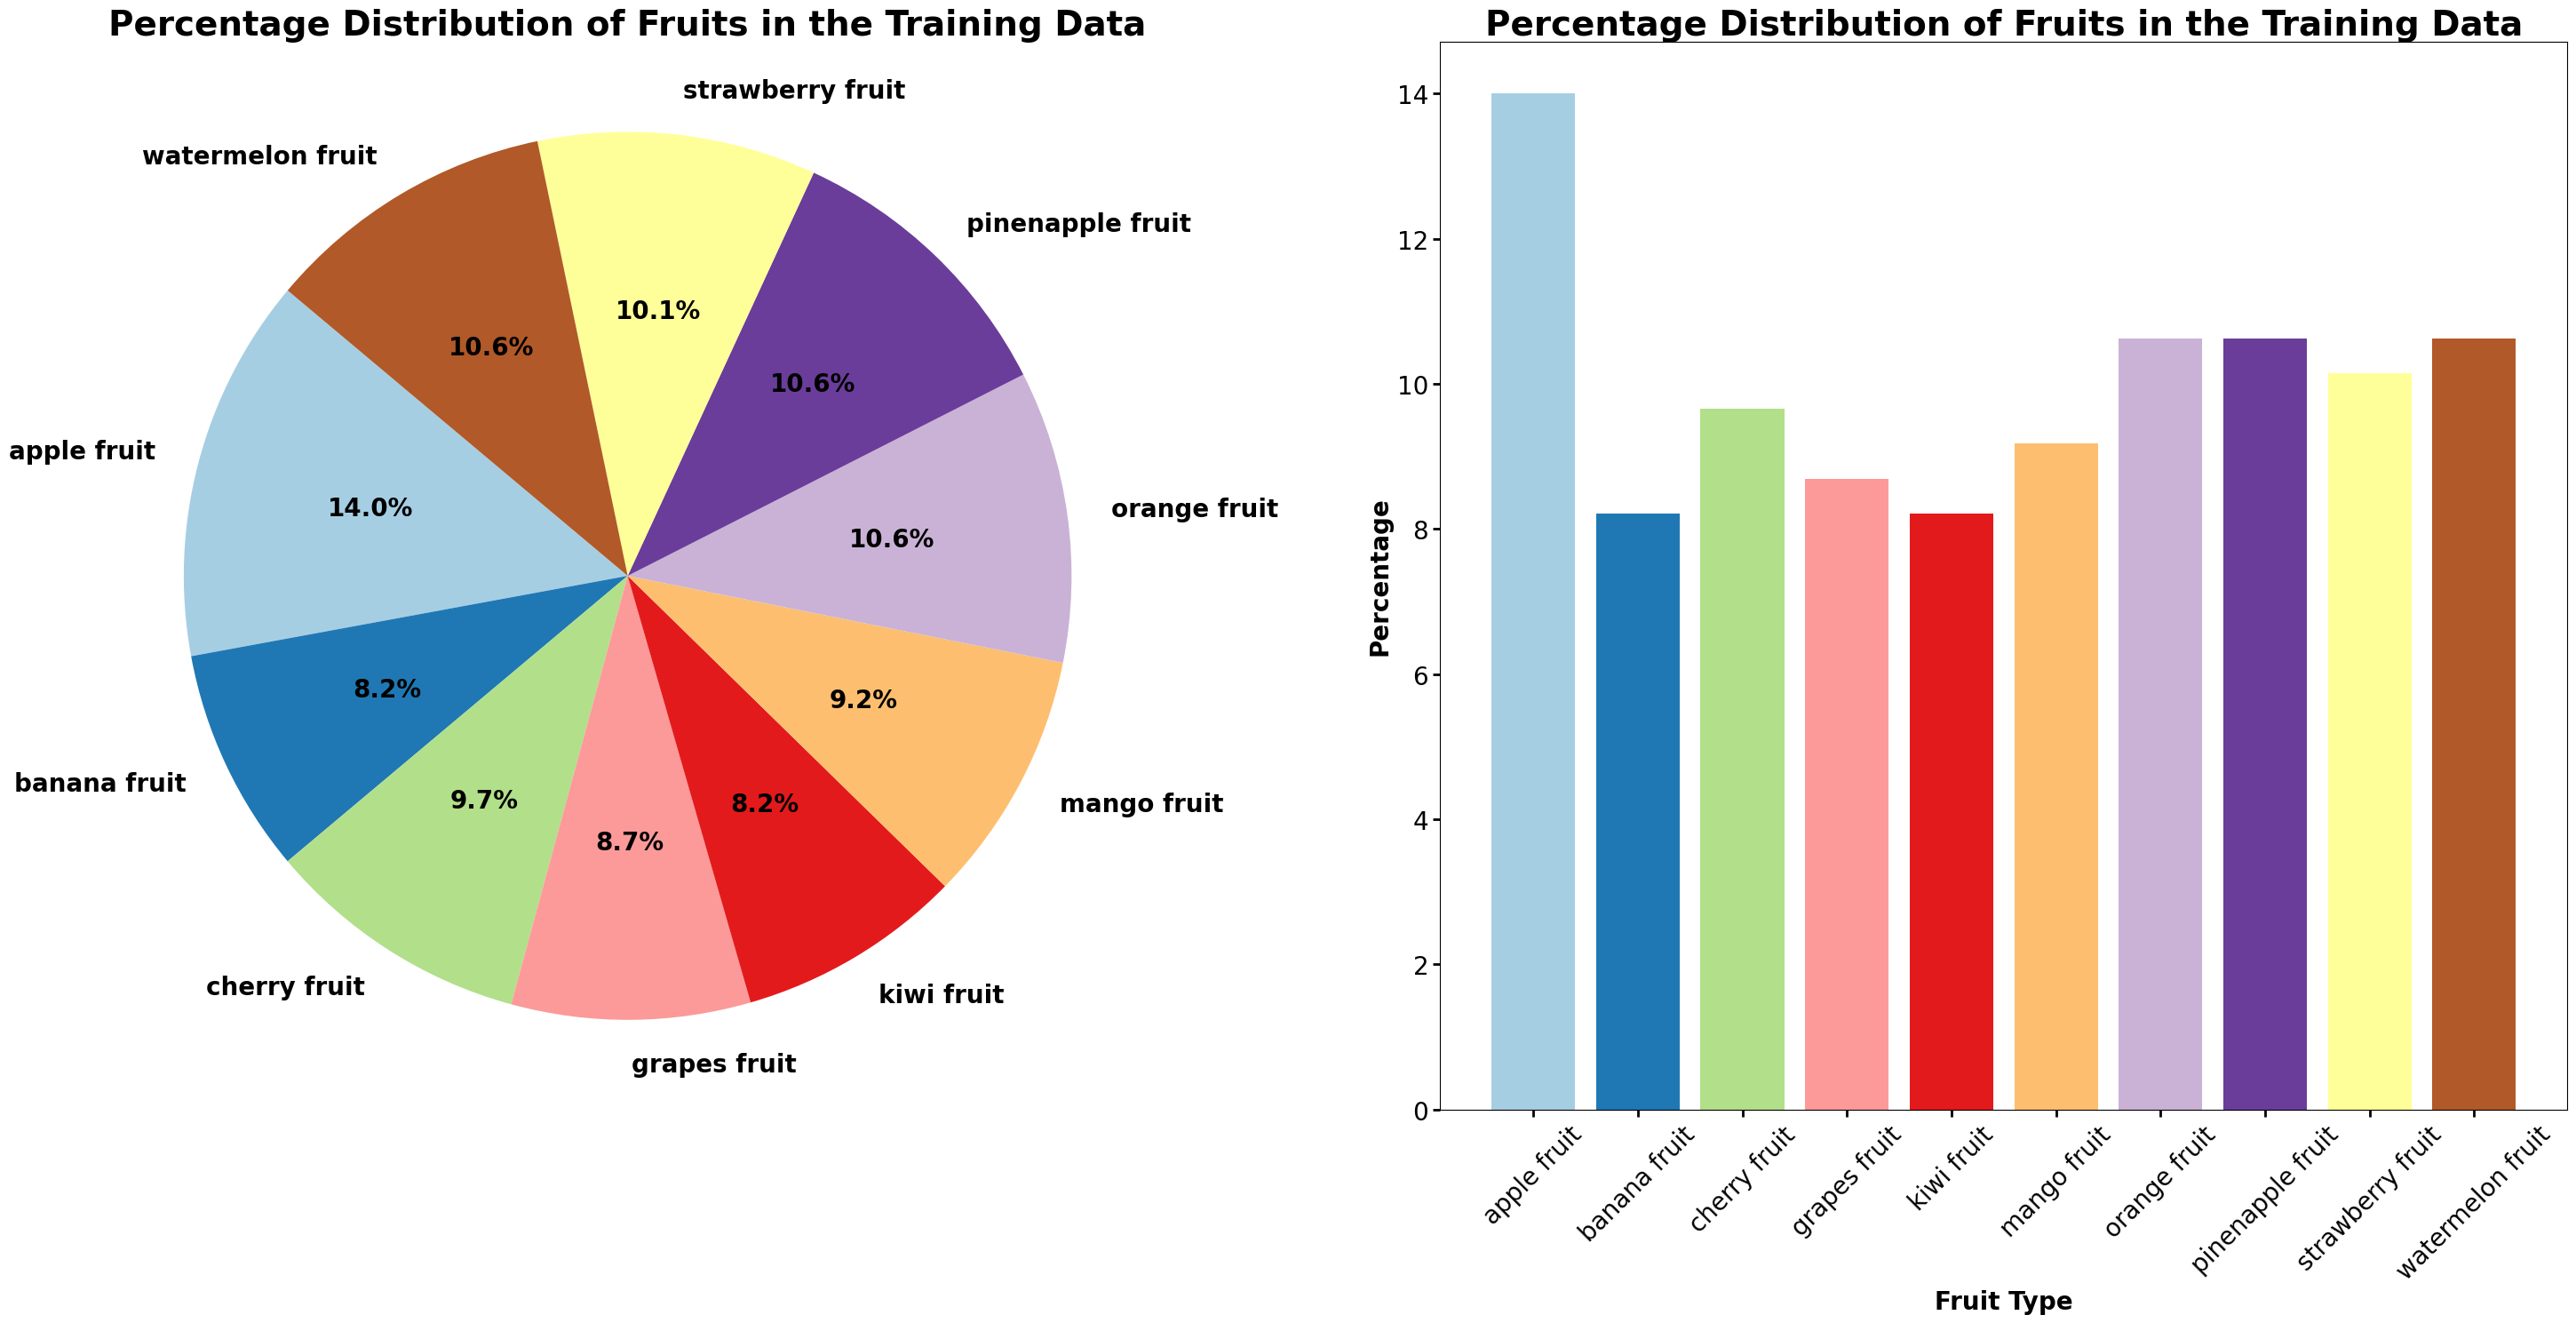

In [ ]:
# Retrieve class indices and corresponding labels
class_indices = train_generator.class_indices
class_labels = list(class_indices.keys())

# Count the number of samples in each class
num_classes = len(class_labels)
class_counts = np.zeros(num_classes)

# Iterate through the batches of the generator and count the occurrences of each class
for _, labels in train_generator:
    class_counts += labels.sum(axis=0)
    if train_generator.batch_index == 0:
        break

# Calculate percentage distribution
class_percentages = (class_counts / class_counts.sum()) * 100

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(30, 15))
# Plot the pie chart
axs[0].pie(class_percentages, labels=class_labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(np.linspace(0, 1, num_classes)), textprops={'fontsize': 20, 'fontweight': 'bold'})
axs[0].set_title('Percentage Distribution of Fruits in the Training Data', fontsize=28, fontweight='bold')
axs[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Plot the bar chart
axs[1].bar(class_labels, class_percentages, color=plt.cm.Paired(np.linspace(0, 1, num_classes)))
axs[1].set_xlabel('Fruit Type', fontsize=20, fontweight='bold')
axs[1].set_ylabel('Percentage', fontsize=20, fontweight='bold')
axs[1].set_title('Percentage Distribution of Fruits in the Training Data', fontsize=28, fontweight='bold')
axs[1].tick_params(axis='x', rotation=45, labelsize=20, width=2, length=6)  # Set the tick parameters for x-axis
axs[1].tick_params(axis='y', labelsize=20, width=2, length=6)  # Set the tick parameters for y-axis

# Make labels bold
for ax in axs:
    ax.xaxis.label.set_fontweight('bold')
    ax.yaxis.label.set_fontweight('bold')

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
num_classes = len(class_labels)
num_classes

10

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Load the MobileNetV2 model with pretrained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers for your classification task
model = models.Sequential([
    base_model,  # Pretrained model
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')  # 10 classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])




In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Reduce learning rate on plateau to make the training more efficient
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Train the model with the callbacks
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,  # Increase the number of epochs
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.4166 - loss: 1.9247 - val_accuracy: 0.8481 - val_loss: 0.6612 - learning_rate: 0.0010
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.9175 - loss: 0.2533 - val_accuracy: 0.8734 - val_loss: 0.4668 - learning_rate: 0.0010
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9460 - loss: 0.1732 - val_accuracy: 0.8987 - val_loss: 0.4298 - learning_rate: 0.0010
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9864 - loss: 0.0509 - val_accuracy: 0.9114 - val_loss: 0.3590 - learning_rate: 0.0010
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9749 - loss: 0.0579 - val_accuracy: 0.8861 - val_loss: 0.4014 - learning_rate: 0.0010
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.9858 - loss: 0.0403 - val_accuracy: 0.9494 - val_loss: 0.1970 - learning_rate: 0.0010
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9908 - loss: 0.0304 - val_accuracy: 

In [ ]:
model.evaluate(train_generator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 1.0000 - loss: 0.0119


[0.009639215655624866, 1.0]

In [18]:
model.evaluate(validation_generator)

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9410 - loss: 0.1569


[0.17769771814346313, 0.9367088675498962]

In [19]:
# Save the model
model.save('fruit_classifier_model.h5')
